# Integral Control Analysis

# Preliminaries

In [33]:
import tellurium as te
import sympy
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sympy.init_printing()

# Helper Functions

In [3]:
def addSymbols(symbolStr):
  """
  Adds the list of symbols in the blank separated string.
  """
  symbols = symbolStr.split(" ")
  globalDct = globals()
  for idx, symbol in enumerate(symbols):
    globalDct[symbol] = sympy.Symbol(symbol)

# Tests
variables = ["aa", "bbb", "fruit"]
symbolStr = " ".join(variables)
addSymbols(symbolStr)
for variable in variables:
  assert(variable in globals())
  delStmt = "del %s" % variable
  exec(delStmt)

In [4]:
def mkSymbolStmt(symbolStr):
  """
  Creaes an executable statement that defines the blank separated symbols in the string.
  """
  symbols = symbolStr.split(" ")
  quotedStrs = ["%s" %s for s in symbols]
  argStrs = ", ".join(symbols)
  return "%s = sympy.symbols(%s)" % (argStrs, quotedStrs)

# Tests
variables = ["aa", "bbb", "fruit"]
symbolStr = " ".join(variables)
stmt = mkSymbolStmt(symbolStr)
exec(stmt)
for variable in variables:
  assert(variable in locals())
  delStmt = "del %s" % variable
  exec(delStmt)

In [39]:
def initSymbols():
    symbols = "dA A A_ref K_AN K_AM N K_PA K_MP rd_A rd_A1 K1 K2 K3 K4 K_A2 Kd_A Kd_M K_Mp A M Mp dP P K_P k_0 M dM K_M rd_M k_0"
    addSymbols(symbols)

initSymbols()

In [6]:
def evaluate(expression, subs):
    result = expression.copy()
    for symbol, value in subs.items():
        result = result.subs(symbol, value)
    return sympy.simplify(result)

# Tests
initSymbols()
dA = A + A * M
result = evaluate(dA, {A: 1})
assert(result == 1 + M)

In [44]:
def calcJacobian(equations):
    # Calculate fixed points and eigenvectors
    xVec = sympy.Matrix([A, P, M])
    fVec = sympy.Matrix(equations)
    return fVec.jacobian(xVec)

# Tests
calcJacobian(equations)

⎡-Kd_A⋅M   0    -A⋅Kd_A⎤
⎢                      ⎥
⎢ K_PA     0       0   ⎥
⎢                      ⎥
⎣   0     K_MP   -Kd_M ⎦

# Implementation of integral feedback control in biological systems
## Reference
Authors: 
Somvanshi, Pramod R.
Patel, Anilkumar K.
Bhartiya, Sharad
Venkatesh, K. V.

Date: 2015

## Analysis

[Feedback Designs](https://drive.google.com/file/d/1GT2hfqxUAo8iiLutB4ccp_mMl59KB8OH/view?usp=sharing)

* $P$ - protein
* $A$ - signaling molecule
* $M$ - metabolite
* $N$ - disturbance
* $E = A_{ref} - A$
* $A_{ref} = \frac{k_0}{K_P}$

* $P \xrightarrow{k_0}\phi$
* $\phi \xrightarrow{K_M P} M$
* $A \xrightarrow{Kd_A A M} \phi$
* $N \xrightarrow{K_A} A$
* $\phi \xrightarrow{K_P A} P$

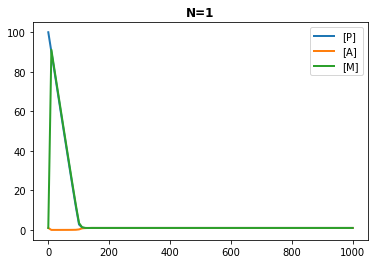

Final A = 1.00


In [7]:
NET_A = """

J1: P -> ; k_0
J3: -> P; K_P * A
J2: -> M; K_M * P
J2a: M ->; Kd_M * M
J4: A -> ; Kd_A * A * M
J5: $N -> A; K_A * N

$N = 1
P = 100
M = 1
A = 1
K_N = 1
k_0 = 1
K_M = 1
Kd_M = 1
K_P = 1
Kd_A = 1
K_A = 1
"""

rr = te.loada(NET_A)
rr.plot(rr.simulate(0, 1000, 100), title="N=%d" % rr.N)
print("Final A = %2.2f" % rr.A)

### Revised Network A

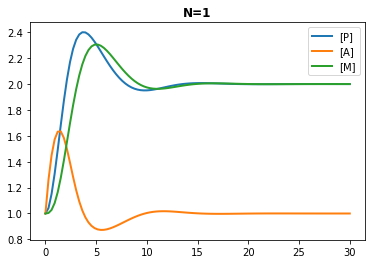

Final A = 1.00


In [8]:
# Have a source of A other than N
NET_A1 = """

J1: P -> ; k_0
J3: -> P; K_P * A
J2: -> M; K_M * P
J2a: M ->; Kd_M * M
J4: A -> ; Kd_A * A * M
J4a: -> A; k_1
J5: $N -> A; K_A * N

$N = 1
P = 1
M = 1
A = 1
K_N = 1
k_0 = 1
K_M = 1
Kd_M = 1
K_P = 1
Kd_A = 1
K_A = 1
k_1 = 1
"""

rr = te.loada(NET_A1)
rr.plot(rr.simulate(0, 30, 100), title="N=%d" % rr.N)
print("Final A = %2.2f" % rr.A)

### Changing $k_0$

Vary k_0 from 0.5 to 3.
Plot fixed points and how they change type.

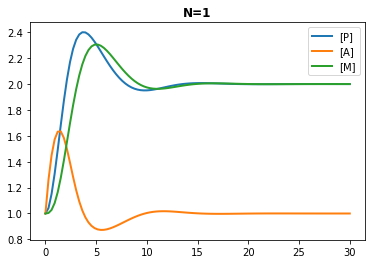

Final A = 1.00


In [9]:
# Have a source of A other than N
NET_A1 = """

J1: P -> ; k_0
J3: -> P; K_P * A
J2: -> M; K_M * P
J2a: M ->; Kd_M * M
J4: A -> ; Kd_A * A * M
J4a: -> A; k_1
J5: $N -> A; K_A * N

$N = 1
P = 1
M = 1
A = 1
K_N = 1
k_0 = 1
K_M = 1
Kd_M = 1
K_P = 1
Kd_A = 1
K_A = 1
k_1 = 1
"""

rr = te.loada(NET_A1)
rr.plot(rr.simulate(0, 30, 100), title="N=%d" % rr.N)
print("Final A = %2.2f" % rr.A)

In [10]:
K0_VALS = [0.5, 0.75, 1.0, 1.5, 2.0, 2.5]

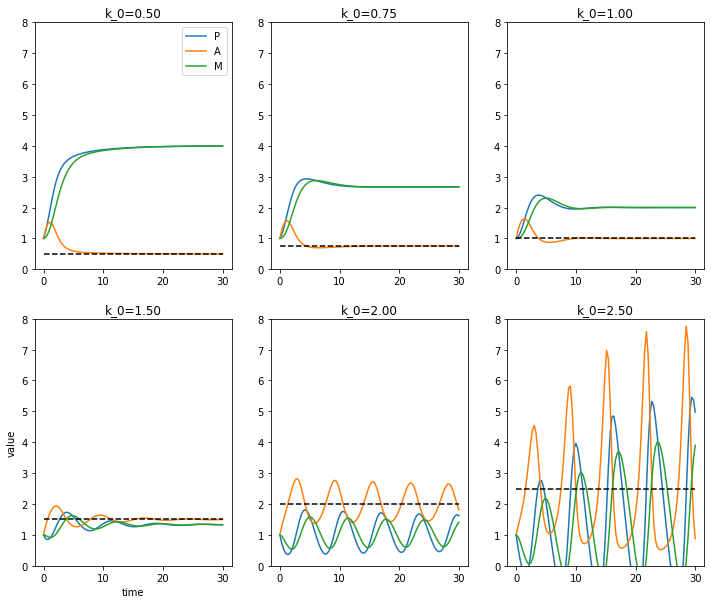

In [11]:
numCol = 3
fig, axes = plt.subplots(2, numCol, figsize=(12, 10))
for idx, k_0 in enumerate(K0_VALS):
    if idx < numCol:
        ax = axes[0, idx]
    else:
        ax = axes[1, idx - numCol]
    rr =  te.loada(NET_A1)
    rr.k_0 = k_0
    data = rr.simulate(0, 30, 100)
    xv = data[:, 0]
    columns = [s[1:-1] for s in data.colnames[1:]]
    for idx1, column in enumerate(columns):
        ax.plot(xv, data[:, idx1+1])
    ax.plot(xv, np.repeat(k_0, len(xv)), linestyle="--", color="black")
    if idx == 0:
        ax.legend(columns)
    if idx == numCol:
        ax.set_xlabel("time")
        ax.set_ylabel("value")
    ax.set_title("k_0=%2.2f" % k_0)
    ax.set_ylim([0, 8])

In [40]:
def initEquations():
  """
  Constructs equations for network A where M inhibits A
  """
  statements = [
      "dA = K_AN * N - Kd_A * A * M",
      "dP = K_PA * A - k_0 ",
      "dM = K_MP * P - Kd_M * M",
      "equations = [dA, dP, dM]",
  ]
  return "; ".join(statements)

exec(initEquations())

In [13]:
def calcEigenVals(xVec, dxVec, subs):
    """
    Calculates the eigenvectors of the linearized derivative matrix
    at the substituted values.
    
    Parameters
    ----------
    xVec: sympy.Mat N X 1
        symbols for states
    dxVec: sympy.Mat N X 1
        expressions for derivatives of state
    subs: dict
        substitutions to make for eigenvalue calculation
        key: symbol
        value: value to use for symbol
        
    Returns
    -------
    dict
        key: sympy.Matrix N X 1
            fixed point
        value: sympy.Matrix N X 1
            eigenvalues
    """
    jacobianMat = dxVec.jacobian(xVec)
    fixedPoints = sympy.solve(dxVec, xVec)
    dct = {}
    jacobianMat = evaluate(jacobianMat, subs)
    for fixedPoint in fixedPoints:
        numericFixedPoint = tuple([sympy.simplify(evaluate(f, subs)) for f in fixedPoint])
        fixedSubs = {s: v for s, v in zip(xVec, numericFixedPoint)}
        mat = evaluate(jacobianMat, fixedSubs)
        mat = evaluate(mat, subs)
        dct[numericFixedPoint] = sympy.Matrix(list(mat.eigenvals().keys()))
        dct[numericFixedPoint] = dct[numericFixedPoint].evalf()
    return dct

# Tests
initSymbols()
exec(initEquations())
subs = {Kd_A: 1, K_P: 1, K_M: 1, k_0: 2.0, Kd_M: 1, N: 1, K_A: 1}
xVec = sympy.Matrix([A, P, M])
dxVec = sympy.Matrix(equations)
dct = calcEigenVals(xVec, dxVec, subs)
assert(list(dct.keys()) == [(2.0, 0.5, 0.5)])

In [14]:
# Analysis of fixed points
subs = {Kd_A: 1, K_P: 1, K_M: 1, k_0: 2.0, Kd_M: 1, N: 1, K_A: 1}
for val in K0_VALS:
    initSymbols()
    subs[k_0] = val
    xVec = sympy.Matrix([A, P, M])
    dxVec = sympy.Matrix(equations)
    dct = calcEigenVals(xVec, dxVec, subs)
    print(dct)

{(0.500000000000000, 2.00000000000000, 2.00000000000000): Matrix([
[-2.19148788395312 - 2.53459329291848e-64*I],
[  -0.404256058023441 - 0.254425889416369*I],
[  -0.404256058023441 + 0.254425889416369*I]])}
{(0.750000000000000, 1.33333333333333, 1.33333333333333): Matrix([
[-1.8284526398601 - 2.49609327051412e-64*I],
[ -0.252440346736618 - 0.588605783081763*I],
[ -0.252440346736618 + 0.588605783081763*I]])}
{(1.00000000000000, 1.00000000000000, 1.00000000000000): Matrix([
[-0.122561166876654 - 0.744861766619744*I],
[-0.122561166876654 + 0.744861766619744*I],
[                       -1.75487766624669]])}
{(1.50000000000000, 0.666666666666667, 0.666666666666667): Matrix([
[0.0512182151373453 - 0.919382383528956*I],
[0.0512182151373453 + 0.919382383528956*I],
[                       -1.76910309694136]])}
{(2.00000000000000, 0.500000000000000, 0.500000000000000): Matrix([
[0.163002589530756 - 1.03378784147109*I],
[0.163002589530756 + 1.03378784147109*I],
[                     -1.8260051790

In [15]:
dct.keys()

dict_keys([(2.50000000000000, 0.400000000000000, 0.400000000000000)])

In [16]:
# Calculate fixed points and eigenvectors
xVec = sympy.Matrix([A, P, M])
fVec = sympy.Matrix(equations)
Jmat = fVec.jacobian(xVec)
Jmat
# Do substitutions


⎡-Kd_A⋅M   0   -A⋅Kd_A⎤
⎢                     ⎥
⎢  K_P     0      0   ⎥
⎢                     ⎥
⎣   0     K_M   -Kd_M ⎦

## Network A

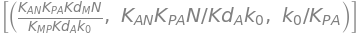

In [41]:
exec(initEquations())
result = sympy.solve([dP, dM, dA], [P, M, A])
result

## Network B

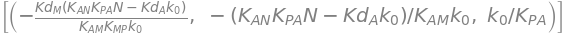

In [43]:
# Design 1(b): M is activating on A, A inhibits P
exec(initEquations())
dA = K_AN * N - Kd_A*A + K_AM * M * A
dP = -K_PA * A + k_0
#
result = sympy.solve([dP, dM, dA], [P, M, A])
result

To make $A$ positive, we need to have a constant influx instead of constant degradation.

In [46]:
jacobianMat = calcJacobian([dP, dM, dA])
jacobianMat

⎡    -K_PA       0      0   ⎤
⎢                           ⎥
⎢      0        K_MP  -Kd_M ⎥
⎢                           ⎥
⎣K_AM⋅M - Kd_A   0    A⋅K_AM⎦

In [48]:
# Positive eigenvalues?
jacobianMat.eigenvals()

**Observations**
1. Can change $k_0$ without affect Jacobian. However, fixed point depends on $k_0$, and so dynamics are still impacted if there is a change in the setpoint.

## Network C

In [19]:
# Design 1(c): Both M and E inhibit A. Again, need a constant influx so that steady states can be achieved.
exec(initEquations())
dA = - K_A * N - Kd_A * M + K1
#
result = sympy.solve([dP, dM, dA], [P, M, A])
result

## Network D

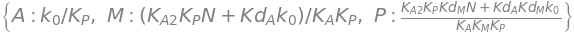

In [20]:
# Design 1(d): E inhibits A; A inhibits P; M activates A
exec(initEquations())
dA = K_A * M - K_A2 * N - Kd_A * A
dP = -K_P * A + k_0  # Since A inhibits, need 0th order kinetics for creation of P
#
result = sympy.solve([dP, dM, dA], [P, M, A])
result

Can construct a table with cases defined by:
* E on A
* M on A
* A on P

Theme: Systematic design of integral control based on:
1. the placement of inhibit vs. activate and use of 0th order kinetics
1. which term(s) have 0th order kinetics

## Tracking for Architecture (a)

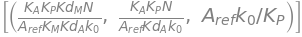

In [21]:
exec(initEquations())
dP = K_P * A - k_0 * A_ref
result = sympy.solve([dP, dM, dA], [P, M, A])
result

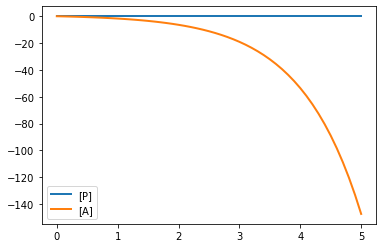

In [22]:
TRACKING_MODEL_A = """
->P; K_P*A
P -> A; K_P * P
A -> P; -KA_1 * A
A ->; KA * $M
// E -> A; KE * A

$M = 1
KP_1 = 1
KP_2 = 1
KA_1 = 1
KA = 1
KE = 1
K_P = 1
"""

rr = te.loada(TRACKING_MODEL_A)
rr.plot(rr.simulate())

# Architecture II: No M

In [23]:
def init2Equations():
  statements = [
      "dA = K_A * N - Kd_A * A * P",
      "dP = K_P * A - k_0",
      "equations = [dA, dP]",
  ]
  return "; ".join(statements)

In [24]:
# Case 2(a): P inhibits A
exec(init2Equations())
sympy.solve([dP], A)

In [25]:
# How much protein is required
newdA = dA.subs(A, k_0/K_P)
sympy.solve(newdA, P)

# Tracking Control

In [26]:
# Can still get integral control with unimolecular degradation for A, M in A. Why biomolecular in model?
exec(initEquations())
dA = K_A * N - Kd_A * (A + M)
#
sympy.solve([dP], A)

Architecture: P degradation depends on tracking molecule, but it cannot change the level of the molecule.

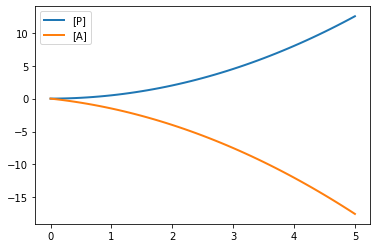

In [27]:
MODEL = """
P -> A; KP_1 * P * M
A -> P; -KA_1 * A
A ->; KA * $M
// E -> A; KE * A

$M = 1
KP_1 = 1
KP_2 = 1
KA_1 = 1
KA = 1
KE = 1
"""

rr = te.loada(MODEL)
rr.plot(rr.simulate())

In [28]:
def init3Equations():
  statements = [
      "dA = K_A * N - Kd_A * A * P",
      "dP = K_P * A - k_0 * M",
      "dM = -k_0 + K_Mp * Mp", 
      "dMp = K_M * M - K_Mp * Mp",
      "equations = [dA, dP]",
  ]
  return "; ".join(statements)

In [29]:
exec(init3Equations())
sympy.solve([dP], A)

In [30]:
exec(init3Equations())
sympy.solve(equations, A)

# Integral Control Paper 1

[Feedback Designs](https://drive.google.com/file/d/1mP0A5jvdlVCtdFCy6QbapDgcsWC_LzmU/view?usp=sharing)

The system including $P$ phosphorylation and dephosphorylation.

* $\dot{S} = k_0 x_0 - k_2 P  + k_6 E$
* $\dot{P} = k_4 x_0 - k_7 P + k_8 Pp$. 
* $\dot{Pp} = k_7 P - k_8 Pp$
* $\dot{x}_1 = k_5 S$

**LaPlace Transforms.**

$s S(s) = k_0 X_0 (s) - k_2 P(s) +k_6 E(s)$

$s P(s) = k_4 X_0 (s) -k_7 P(s) + k_8 Pp(s)$

$s Pp(s) = k_7 P(s) - k_8 Pp(s)$
Or, $Pp(s) = P(s) \frac{k_7}{s + k_8}.$

So,
\begin{align*}
sP(s) & = & k_4 X_0 (s) -k_7 P(s) + k_8 Pp(s) \\
& = & k_4 X_0 (s) -k_7 P(s) + k_8 P(s) \frac{k_7}{s + k_8} \\
P(s)& = & X_0 (s) \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}
\end{align*}

With this,
\begin{align*}
S(s) = X_0(s) \frac{ k_0 - k_2 \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}}{s + k_7} +  E(s) \frac{k_6}{s + k_3}
\end{align*}

\begin{align*}
X_1(s) & = & \frac{k_5}{s}S(s) \\
& = & X_0(s) \frac{k_5}{s}  \frac{ k_0  - k_2 \frac{k_4 }{s + k_7 - \frac{k_7 k_8 }{s + k_8}}}{s + k_7} +  E(s) \frac{k_5}{s} \frac{k_6}{s + k_3}
\end{align*}

This suggests that the impulse response is finite but the step response is unbounded. Also, $x_t(t) \neq 0$ for a non-zeror $e(t)$.

Note that $k_8$ must be small for the integrator to work.
So,
\begin{align*}
X_1(s) & \approx & X_0(s) \frac{k_5}{s}  \frac{ k_0 - k_2 \frac{k_4 }{s + k_7 }}{s + k_7} +  E(s) \frac{k_5}{s} \frac{k_6}{s + k_3}
\end{align*}

Observe that for an impulse $x_0$, 
$x_1 (\infty) =  k_5 \frac{ k_0 k_7 - k_2 k_4}{ k_7^2} .$

Solve for $H_E (s) = \frac{X_1(s)}{E(s)}$.

$X_0(s) = 0$

$s S(s) =  - k_3 S(s) + k_6 E(s)$ And so,
$S(s) = \frac{k_6 E(s)}{s + k_3}$

Further,
$X_1(s) = \frac{k_5}{s}\frac{k_6 E(s)}{s + k_3} .$

Suggest that there is an error with the impulse response, and the system does not converge with the step response.

Solve for transfer function: $H(s) = \frac{X_1(s)}{X_0(s)}$.

$s S(s) = X_0 (s) \frac{k_0 - k_2 k_4 }{s + k_3}$

$ 
\begin{align*}
X_1 (s) & = &  \frac{k_5}{s} S(s) \\
& = & X_0 (s) \frac{k_5}{s^2}  \frac{k_0 - k_2 k_4 }{s + k_3} \\
H(s) & = & \frac{1}{s^2} \frac{k_0 - k_2 k_4 }{s + k_3}
\end{align*}
$

$H (0)$ is constant and so the output tracks the input. However, the system has complex dynamics.

In [31]:
# Simulation
MODEL = """
$X0 -> S; k0*X0 - k2*P
S -> X1; k4*X0
S -> P; k4*X0
P -> Pp; k7*P
Pp -> P; k8*Pp

$X0 = 1
k0 = 1
k2 = 1
k3
"""

# Integral Paper 2
Analysis of Herbert's early draft.

In [32]:
addSymbols("P S S_1 S_2 _3")

## Model

* $P \xrightarrow{v_r} S$ has kinetics $v_r (P, E_r) = \frac{k_r E_r P}{K_{M_{r}} + P}$
* $S \xrightarrow{v_f} P$ has kinetics $v_f (S, E_f)
= k_f E_f$ because $S$ saturates the reaciton.

Consider region where $K_{M_r} >> P$ and $E_r$ is stable.
Then, $v_r(P, E_r) \approx k_r E_r P$.

The LaPlace transforms are:
* $\frac{S(s)}{P(s)} = \frac{1}{s} k_r E_r$
* $\frac{S(s)}{E(s)} = \frac{T}{s^2} -  \frac{1}{s} k_f E_f(s)$